In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange

from utils.trading_model import *
from utils.experiment_utils import *
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2


# Import data

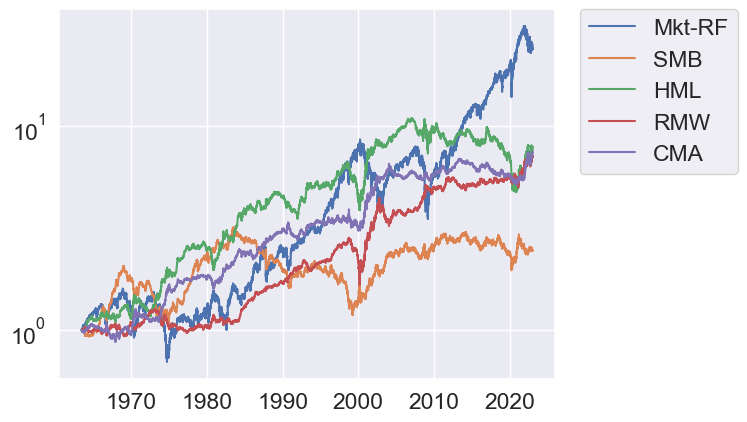

In [2]:
returns = pd.read_csv('data/ff5_no_rf.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

columns = returns.columns
plt.plot((returns[columns]+1).cumprod(axis=0), label=columns)
# fix legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.yscale("log");

# Covariance predictors

In [3]:
### Parameters
rw_memory = 125
ewma_halflife = 63
iewma_pair = (21,63)
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

In [4]:
# Rolling window 
rw = rolling_window(returns, rw_memory) 

In [5]:
# EWMA
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

In [6]:
# IEWMA  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [7]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/factor_returns/mgarch_ff5.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

In [8]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [10]:
# Prescient 
prescient = {}
quarter_prev = None
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    if quarter != quarter_prev:
        cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
        mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
        quarter_prev = quarter
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [12]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1965-06-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [13]:
names = ["RW", "EWMA", "IEWMA", "MGARCH", "CM-IEWMA", "PRESCIENT"]

predictors_temp = [rw, ewma, iewma, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

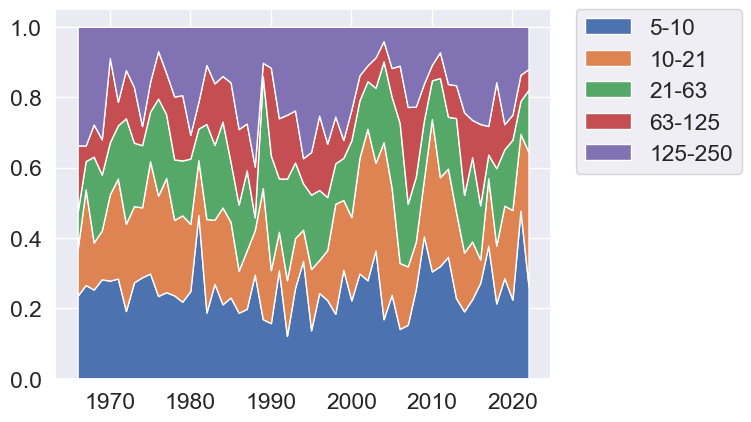

In [14]:
quarterly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

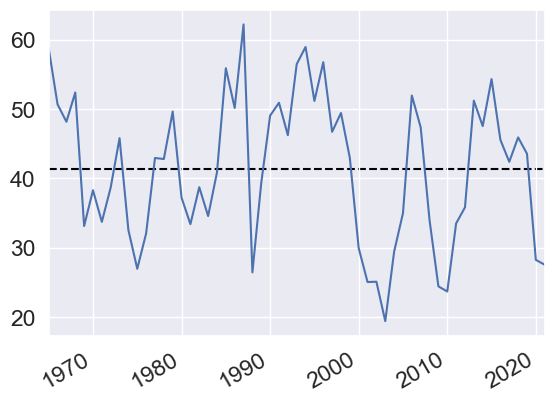

In [16]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# MSEs

In [17]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.8f}")
    print(f"std: {MSE_temp.std():.8f}")
    print(f"max: {MSE_temp.max():.8f}")


RW
mean: 0.00000034
std: 0.00000188
max: 0.00002393

EWMA
mean: 0.00000034
std: 0.00000186
max: 0.00002386

IEWMA
mean: 0.00000033
std: 0.00000183
max: 0.00002393

MGARCH
mean: 0.00000032
std: 0.00000183
max: 0.00002436

CM-IEWMA
mean: 0.00000032
std: 0.00000182
max: 0.00002431

PRESCIENT
mean: 0.00000031
std: 0.00000176
max: 0.00002292


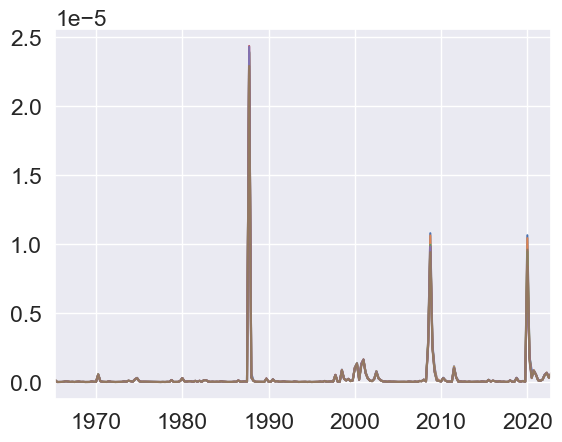

In [18]:
plt.figure()
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()
    MSE_temp.plot()

# Log likelihoods

In [24]:
pd.Series(predictor)

1965-06-28              Mkt-RF           SMB           HML  ...
1965-06-29              Mkt-RF           SMB           HML  ...
1965-06-30              Mkt-RF           SMB           HML  ...
1965-07-01                  Mkt-RF           SMB           H...
1965-07-02                  Mkt-RF           SMB           H...
                                    ...                        
2022-12-23              Mkt-RF       SMB       HML       RMW...
2022-12-27              Mkt-RF       SMB       HML       RMW...
2022-12-28              Mkt-RF       SMB       HML       RMW...
2022-12-29              Mkt-RF       SMB       HML       RMW...
2022-12-30              Mkt-RF       SMB       HML       RMW...
Length: 14478, dtype: object

In [26]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing IEWMA log-likelihood...
Computing MGARCH log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing PRESCIENT log-likelihood...


In [47]:
from experiments.regret_and_smoothing_utils import compute_regrets, ewma

In [49]:
smooth = ewma(cm_iewma, halflife=250)

<Axes: >

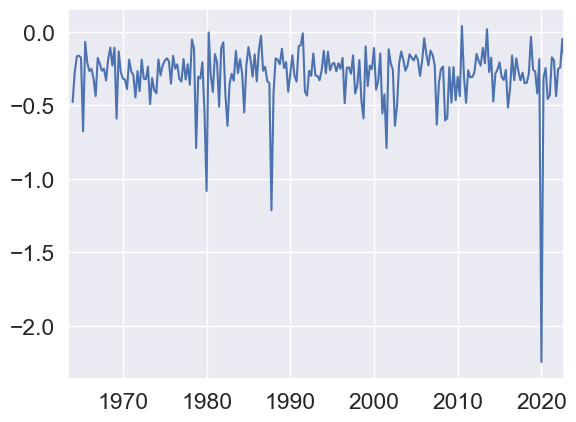

In [44]:
regrets = compute_regrets(returns, cm_iewma)
quarterly_regrets = regrets.resample("Q").mean()
quarterly_regrets.plot()

<Axes: >

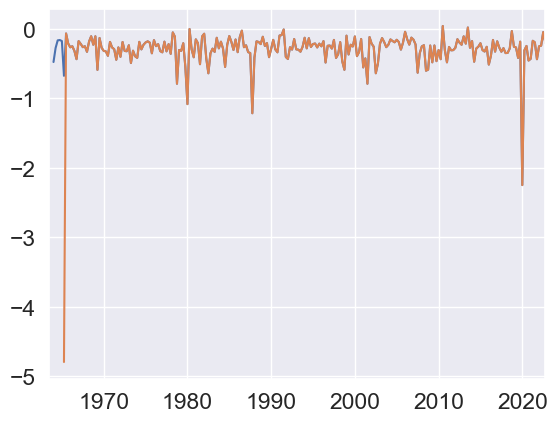

In [43]:
regrets_quarter.plot()
regrets_quarter2.plot()

<Axes: >

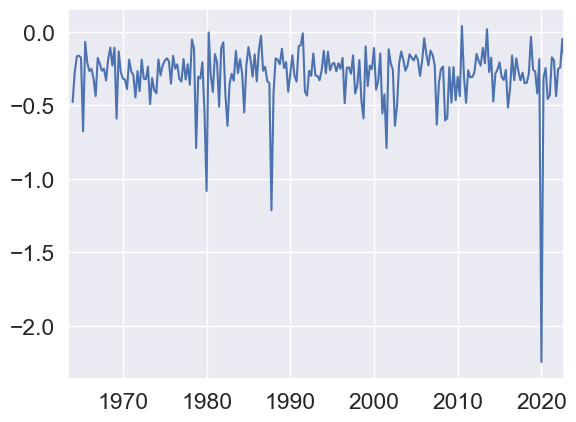

In [32]:
regrets_quarter.plot()

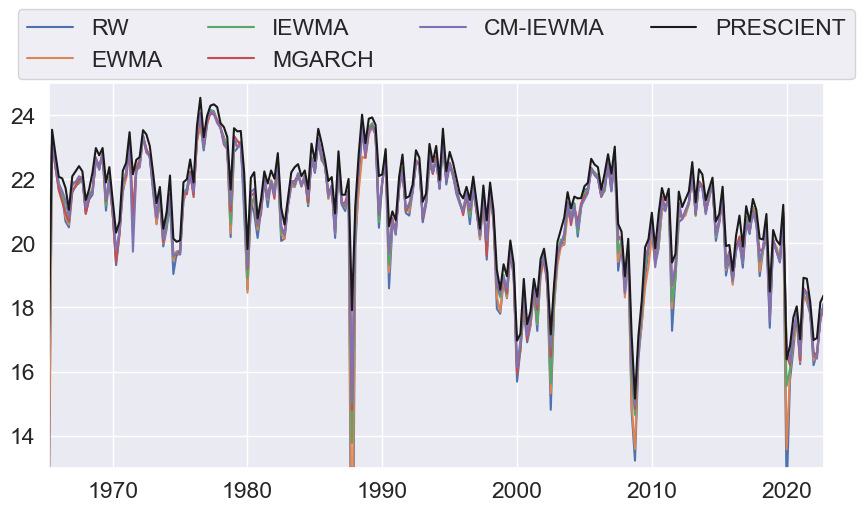

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(13,25);

# Regrets

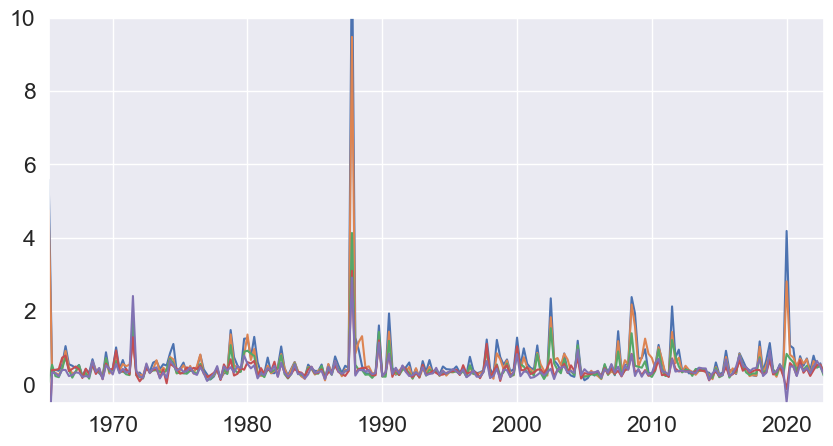

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.ylim(-0.5,10);


### Compare CM-IEWMA with MGARCH

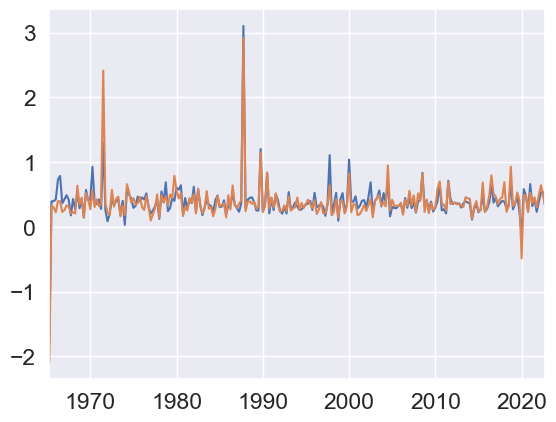

In [29]:
regret_mgarch = regrets["MGARCH"].resample("Q").mean()
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

regret_mgarch.plot(label="MGARCH")
regret_cm_iewma.plot(label="CM-IEWMA");
# plt.legend();

In [30]:
cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 51% of the time


### Regret CDF plots

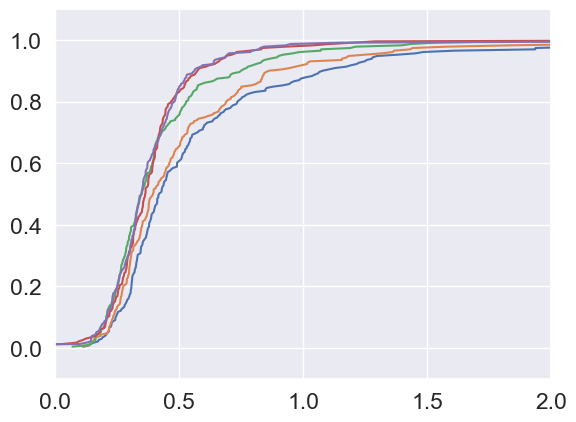

In [31]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(0,2)
plt.ylim(-0.1,1.1);
# plt.legend();

### Regret metrics

In [32]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW & 0.6 & 0.9 & 12.2 \\
   EWMA & 0.6 & 0.7 & 9.5 \\
   IEWMA & 0.4 & 0.3 & 4.1 \\
   MGARCH & 0.4 & 0.3 & 3.1 \\
   CM-IEWMA & 0.4 & 0.3 & 2.9 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolio optimization

In [12]:
from cvx.backtest.portfolios import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02
excess = False

### Equally weighted

In [28]:
traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


In [35]:
create_table(traders_eq_w, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.9\% & 2.1\% & 1.4 & 15\% \\
   EWMA & 2.9\% & 2.0\% & 1.4 & 15\% \\
   IEWMA & 3.0\% & 2.0\% & 1.5 & 14\% \\
   MGARCH & 3.2\% & 2.0\% & 1.6 & 12\% \\
   CM-IEWMA & 2.9\% & 2.1\% & 1.4 & 15\% \\
   \hline
   PRESCIENT & 3.3\% & 2.0\% & 1.7 & 12\% \\
   \bottomrule
\end{tabular}


### Minimum risk

In [26]:
traders_min_risk = MinRisk(returns, [cm_iewma], ["CM-IEWMA"], start_date, end_date).backtest(additonal_cons)

100%|██████████| 1/1 [01:59<00:00, 119.37s/it]


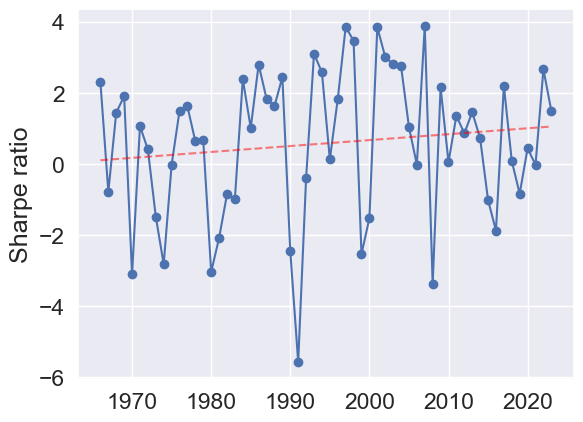

In [112]:
trader = traders_min_risk["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [40]:
create_table(traders_min_risk, sigma_tar, rf, excess)

False
\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 1.3\% & 2.2\% & 0.6 & 20\% \\
   EWMA & 1.4\% & 2.1\% & 0.7 & 18\% \\
   IEWMA & 1.2\% & 2.1\% & 0.6 & 17\% \\
   MGARCH & 1.8\% & 2.1\% & 0.9 & 15\% \\
   CM-IEWMA & 1.2\% & 2.1\% & 0.5 & 21\% \\
   \hline
   PRESCIENT & 1.0\% & 2.0\% & 0.5 & 22\% \\
   \bottomrule
\end{tabular}


### Maximum diversification 

In [41]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 17%|█▋        | 1/6 [00:26<02:10, 26.05s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more inform

In [42]:
create_table(traders_max_diverse, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 1.4\% & 2.2\% & 0.7 & 19\% \\
   EWMA & 1.5\% & 2.1\% & 0.7 & 19\% \\
   IEWMA & 1.4\% & 2.1\% & 0.7 & 19\% \\
   MGARCH & 2.0\% & 2.1\% & 1.0 & 16\% \\
   CM-IEWMA & 1.4\% & 2.1\% & 0.7 & 18\% \\
   \hline
   PRESCIENT & 1.3\% & 2.0\% & 0.7 & 18\% \\
   \bottomrule
\end{tabular}


### Risk parity 

In [43]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

 50%|█████     | 3/6 [01:11<01:10, 23.39s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 67%|██████▋   | 4/6 [01:39<00:50, 25.39s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 6/6 [02:33<00:00, 25.53s/it]


In [44]:
create_table(traders_risk_par, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 1.6\% & 2.1\% & 0.7 & 19\% \\
   EWMA & 1.7\% & 2.1\% & 0.8 & 18\% \\
   IEWMA & 1.6\% & 2.1\% & 0.8 & 18\% \\
   MGARCH & 2.0\% & 2.1\% & 1.0 & 16\% \\
   CM-IEWMA & 1.5\% & 2.1\% & 0.7 & 17\% \\
   \hline
   PRESCIENT & 1.4\% & 2.0\% & 0.7 & 17\% \\
   \bottomrule
\end{tabular}


### Mean variance

In [13]:
from experiments.utils.portfolio_backtests import MeanVariance

r_hat_ewma = pd.DataFrame(dict(_ewma_mean(returns, halflife=63))).T

mean_predictors = [r_hat_ewma for name in names]

traders_mean_var = MeanVariance(returns, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 6/6 [03:34<00:00, 35.68s/it]


In [14]:
create_table(traders_mean_var, None, rf, excess, prescient=True)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 7.5\% & 2.2\% & 3.3 & 4\% \\
   EWMA & 7.2\% & 2.1\% & 3.4 & 4\% \\
   IEWMA & 7.1\% & 2.1\% & 3.3 & 4\% \\
   MGARCH & 7.3\% & 2.2\% & 3.3 & 3\% \\
   CM-IEWMA & 6.9\% & 2.2\% & 3.2 & 4\% \\
   \hline
   PRESCIENT & 6.5\% & 1.9\% & 3.3 & 4\% \\
   \bottomrule
\end{tabular}


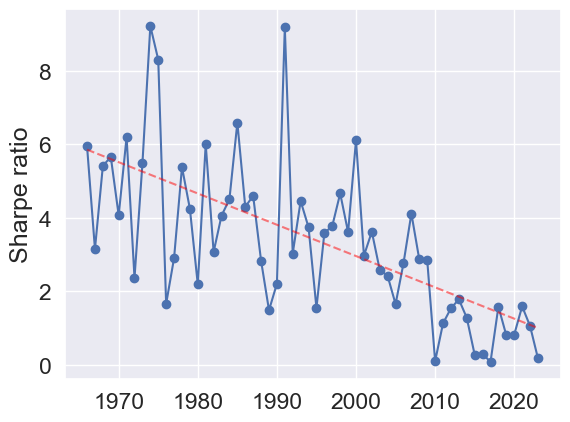

In [15]:
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()